# Playground 7:  Segmentation workflow for Connexin-43

This notebook contains the workflow for connexin-43, and serves as a starting point for developing a classic segmentation workflow if your data shows similar morphology as connexin-43.

----------------------------------------

Cell Structure Observations:

* [Connexin-43](https://www.allencell.org/cell-observations/category/connexin43)

----------------------------------------

Key steps of the workflows:

* Auto-Contrast intensity normalization
* 2D Gaussian smoothing slice by slice
* 3D Spot filter 
* Size thresholding


In [1]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.seg_dot import dot_3d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects

## Loading the data

In [2]:
FILE_NAME = '../../data/GJA1/original/3500001785_100X_20180306_6-Scene-3-P27-E07.czi'
reader = AICSImage(FILE_NAME) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(1, 7, 60, 624, 924)


## Preview of the image

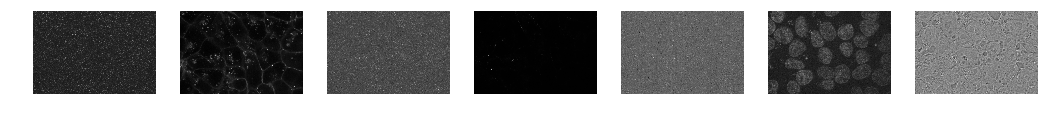

In [3]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS>1:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)

In [4]:
#####################
structure_channel = 3
#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()
view(single_fluorescent_view(struct_img0))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

## Image segmentation

### Step 1: Pre-Processing

About selected algorithms and tuned parameters

* **Intensity normalization**: Parameter `intensity_scaling_param` has two options: two values, say `[A, B]`, or single value, say `[K]`. For the first case, `A` and `B` are non-negative values indicating that the full intensity range of the stack will first be cut-off into **[mean - A * std, mean + B * std]** and then rescaled to **[0, 1]**. The smaller the values of `A` and `B` are, the higher the contrast will be. For the second case, `K`>0 indicates min-max Normalization with an absolute intensity upper bound `K` (i.e., anything above `K` will be chopped off and reset as the minimum intensity of the stack) and `K`=0 means min-max Normalization without any intensity bound.

    * Parameter:  `intensity_scaling_param = [1, 40]`


* **Smoothing**: 2D gaussian smoothing slice by slice with `gaussian_smoothing_sigma = 1`.  The large the value is, the more the image will be smoothed. 

In [5]:
################################
## PARAMETERS for this step ##
intensity_scaling_param = [1, 40]
gaussian_smoothing_sigma = 1
################################

# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

# smoothing with 2d gaussian filter slice by slice 
structure_img_smooth = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=gaussian_smoothing_sigma)

intensity normalization: normalize into [mean - 1 x std, mean + 40 x std] 
intensity normalization completes


In [6]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

#### If the contrast looks too off, you can tune the normalization parameters.

We have a function to give you some suggestions. If you have certain preference, you can adjust the values based on the suggestion.

***After you decide the parameters, you have to re-run the code above with the new parameter*** `intensity_scaling_param = ` 

In [7]:
from aicssegmentation.core.pre_processing_utils import suggest_normalization_param
suggest_normalization_param(struct_img0)

mean intensity of the stack: 439.550545981796
the standard deviation of intensity of the stack: 76.74768376282486
0.9999 percentile of the stack intensity is: 4049.0
minimum intensity of the stack: 350
maximum intensity of the stack: 4049
suggested upper range is 47.0, which is 4046.6916828345647
suggested lower range is 1.0, which is 362.80286221897114
So, suggested parameter for normalization is [1.0, 47.0]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


### Step 2: Core Algorithm

#### Apply 3D Spot filter (S3)

Parameter syntax: `[[scale_1, cutoff_1], [scale_2, cutoff_2], ....]` 
* `scale_x` is set based on the estimated radius of your target dots. For example, if visually the diameter of the dots is usually 3~4 pixels, then you may want to set `scale_x` as `1` or something near `1` (like `1.25`). Multiple scales can be used, if you have dots of very different sizes.  
* `cutoff_x` is a threshold applied on the actual filter reponse to get the binary result. Smaller `cutoff_x` may yielf more dots and fatter segmentation, while larger `cutoff_x` could be less permisive and yield less dots and slimmer segmentation. 

Parameter:  `s3_param = [[1, 0.031]]`


In [8]:
################################
## PARAMETERS for this step ##
s3_param = [[1, 0.031]]
################################

bw = dot_3d_wrapper(structure_img_smooth, s3_param)

In [9]:
# view the segmentation result
viewer_bw = view(segmentation_quick_view(bw))
viewer_bw

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

##### After quickly visualizing the segmentation results, you can also visualize the segmentation and original image side by side

##### You may select an ROI to inspect the details

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_bw'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]. 

In [10]:
# Option 1:
view(seg_fluo_side_by_side(struct_img,bw,roi=['ROI',viewer_bw.roi_slice()]))

# Option 2: 
#view(seg_fluo_side_by_side(struct_img,bw,roi=['M',[570,370,730,440]]))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

##### Is the segmentation satisfactory? Here are some possible criteria:

------------------
* Is there any spot should be detected but not? Try to reduce `cutoff_x`
* Is there any spot should not be detected but actually appear in the result? Try to increase `cutoff_x` or try a larger `scale_x`
* Is the segmented size of the spots fatter than it should be? Try to increase `cutoff_x` or try a smaller `scale_x`
* Is there any spot that should be solid but segmented as a ring? Try to increase `scale_x`
* Are you observing spots with very different sizes? Try multiple sets of `scale_x` and `cutoff_x` 
--------------------

#### If the results are satisfactory, go to next step; otherwise, try to tweak the parameters based on the above suggestions. 

Assumption: the segmentation result is saved in a variable named `bw`.

#### Step 3: Post-Processing 

In [12]:
################################
## PARAMETERS for this step ##
minArea = 5
################################

seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [13]:
viewer_final = view(segmentation_quick_view(seg))
viewer_final

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

### You can also focus your inspection on a small ROI

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_final'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]. 

In [14]:
# Option 1: 
view(seg_fluo_side_by_side(struct_img, seg, roi=['ROI',viewer_final.roi_slice()]))

# Option 2: 
#view(seg_fluo_side_by_side(struct_img, seg, roi=['M',[267,474, 468, 605]]))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

### You may also physically save the segmentation results into a ome.tif file

In [27]:
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
writer = OmeTiffWriter('../../data/GJA1/result/test_segmentation.tiff')
writer.save(out)